In [1]:
import numpy as np
from numpy import array

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
from PIL import Image
import glob
from pickle import dump, load
from nltk.translate.bleu_score import corpus_bleu

from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## Read Dataset

In [2]:
project_path = "NeuraIC/"

In [3]:
if os.path.isdir('Flickr8k_images') == False:
    os.mkdir('Flickr8k_images')
if os.path.isdir('Flickr8k_captions') == False:
    os.mkdir('Flickr8k_captions')

In [4]:
# from zipfile import ZipFile
# with ZipFile(project_path+'Flickr8k_Dataset.zip', 'r') as z:
#     z.extractall("Flickr8k_images")

In [5]:
# from zipfile import ZipFile
# with ZipFile(project_path+'Flickr8k_text.zip', 'r') as z:
#     z.extractall("Flickr8k_captions")

In [6]:
file_data = open("Flickr8k_captions/Flickr8k.token.txt",'r')
image_files = []
captions = []
for line in file_data.readlines():
    spl = line.split("#")
    image_files.append(spl[0])
    captions.append(str(spl[1]))
del file_data

In [7]:
img_cap_dict = {"images":image_files,"captions":captions}

In [8]:
img_cap_df = pd.DataFrame(img_cap_dict,columns=img_cap_dict.keys())

In [9]:
img_cap_df.head()

,images,captions
0,1000268201_693b08cb0e.jpg,0\tA child in a pink dress is climbing up a se...
1,1000268201_693b08cb0e.jpg,1\tA girl going into a wooden building .\n
2,1000268201_693b08cb0e.jpg,2\tA little girl climbing into a wooden playho...
3,1000268201_693b08cb0e.jpg,3\tA little girl climbing the stairs to her pl...
4,1000268201_693b08cb0e.jpg,4\tA little girl in a pink dress going into a ...


## Preprocess Data

In [10]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
def clean_captions(caption):
    # tokenize
    caption = caption.split()
    # convert to lower case
    caption = [word.lower() for word in caption]
    # remove punctuation from each token
    caption = [w.translate(table) for w in caption]
    # remove hanging 's' and 'a'
    caption = [word for word in caption if len(word)>1]
    # remove tokens with numbers in them
    caption = [word for word in caption if word.isalpha()]
    # store as string
    return ' '.join(caption)

In [11]:
img_cap_df["captions"] = img_cap_df["captions"].apply(lambda x:clean_captions(x))

In [12]:
img_cap_df["captions"].values[:10]

array(['child in pink dress is climbing up set of stairs in an entry way',
       'girl going into wooden building',
       'little girl climbing into wooden playhouse',
       'little girl climbing the stairs to her playhouse',
       'little girl in pink dress going into wooden cabin',
       'black dog and spotted dog are fighting',
       'black dog and tricolored dog playing with each other on the road',
       'black dog and white dog with brown spots are staring at each other in the street',
       'two dogs of different breeds looking at each other on the road',
       'two dogs on pavement moving toward each other'], dtype=object)

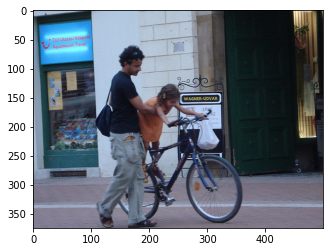

############## Image Description ###############

3895                      man helps little girl ride bike
3896    man helps young girl balance on bicycle that i...
3897                  man holding onto small girl on bike
3898             man is helping girl sit on large bicycle
3899    this man is helping girl in an orange dress on...
Name: captions, dtype: object


In [13]:
img_file = img_cap_df["images"].values[np.random.randint(img_cap_df.shape[0])]
img_caption = img_cap_df["captions"][img_cap_df["images"] == img_file]

x=plt.imread("Flickr8k_images/Flicker8k_Dataset/"+img_file)
plt.imshow(x)
plt.show()
print("############## Image Description ###############\n")
print(img_caption)

In [14]:
img_cap_df.shape

(40460, 2)

## Prepare Photo Data

In [15]:
# Below path contains all the images
images = 'Flickr8k_images/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [16]:
img[:3]

['Flickr8k_images/Flicker8k_Dataset/3056530884_27766059bc.jpg',
 'Flickr8k_images/Flicker8k_Dataset/3640661245_c8c419524d.jpg',
 'Flickr8k_images/Flicker8k_Dataset/3201666946_04fe837aff.jpg']

In [17]:
# Below file conatains the names of images to be used in train data
train_images_file = "Flickr8k_captions/Flickr_8k.trainImages.txt"
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [18]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr8k_captions/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [19]:
# load clean descriptions into memory
def load_train_descriptions(train_images):
    descriptions = dict()
    for filepath in train_images:
        # get filename
        filename = os.path.basename(filepath)
        img_captions = img_cap_df["captions"][img_cap_df["images"] == filename].values
        img_captions = ['startseq ' + cap + ' endseq' for cap in img_captions]
        descriptions[filename] = img_captions
    return descriptions

In [20]:
train_data = load_train_descriptions(train_img)

In [21]:
test_data = load_train_descriptions(test_img)

In [22]:
# Load the inception v3 model
InceptionV3_model = InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(InceptionV3_model.input, InceptionV3_model.layers[-2].output)

In [23]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [24]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [25]:
# Encode all the train images
train_features = {}
for img in train_img:
    train_features[os.path.basename(img)] = encode(img)

In [26]:
# Encode all the test images
test_features = {}
for img in test_img:
    test_features[os.path.basename(img)] = encode(img)

In [25]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(descriptions)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    return max(len(d.split()) for d in descriptions)
 
 # map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

## Prepare Description Data

In [26]:
# Create a list of all the captions
all_descriptions = ['startseq ' + des + ' endseq' for des in img_cap_df["captions"].values]

In [27]:
# prepare tokenizer
tokenizer = create_tokenizer(all_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(all_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 8765
Description Length: 34


In [28]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# if os.path.isdir('glove') == False:
#     os.mkdir('glove')

# glove_dir = "/home/abhishek/Desktop/NeuraIC/"
# from zipfile import ZipFile
# with ZipFile(glove_dir+'glove.zip', 'r') as z:
#     z.extractall("glove")

In [32]:
# Get Glove word embeddings
# !wget -O glove http://nlp.stanford.edu/data/glove.6B.zip

In [29]:
# Load Glove vectors
import os
embeddings_index = {} # empty dictionary
print(os.path)
f = open(os.path.join("glove/", 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

<module 'posixpath' from '/usr/lib/python3.8/posixpath.py'>
Found 400000 word vectors.


In [30]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix.shape

(8765, 200)

In [39]:
def create_sequences(max_length, desc_list, photo,tokenizer, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [40]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, max_length,tokenizer, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key]
            in_img, in_seq, out_word = create_sequences(max_length, desc_list, photo,tokenizer, vocab_size)
            yield [in_img, in_seq], out_word

## Build Model

In [34]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model

In [40]:
# define the model
model = define_model(vocab_size, max_length)

In [41]:
# set Glove vectors to embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [42]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      1753000     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [42]:
# plot model flow
# plot_model(model, to_file='model.png', show_shapes=True)

## Train Model

In [43]:
# Defining a helper function to save the model after each epoch 
# in which the loss decreases 
filepath = project_path+'model_img_cap_pad.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint, es, reduce_alpha]

In [45]:
# train the model
epochs = 20
train_steps = len(train_data)
val_steps = len(train_data)
# create the data generator
train_generator = data_generator(train_data,train_features,max_length,tokenizer,vocab_size)
test_generator = data_generator(test_data,test_features,max_length,tokenizer,vocab_size)
model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=train_steps,validation_data=(test_generator),validation_steps=val_steps,callbacks=callbacks, verbose=1)
# save model
# model.save(project_path+'model_img_cap_pad.h5')

/home/abhishek/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
6000/6000 [==============================] - 1674s 278ms/step - loss: 5.0425 - val_loss: 4.0567

Epoch 00001: val_loss improved from inf to 4.05673, saving model to NeuraIC/model_img_cap_pad.h5
Epoch 2/20
6000/6000 [==============================] - 1646s 274ms/step - loss: 3.8670 - val_loss: 3.9353

Epoch 00002: val_loss improved from 4.05673 to 3.93534, saving model to NeuraIC/model_img_cap_pad.h5
Epoch 3/20
6000/6000 [==============================] - 1599s 266ms/step - loss: 3.5755 - val_loss: 3.9266

Epoch 00003: val_loss improved from 3.93534 to 3.92664, saving model to NeuraIC/model_img_cap_pad.h5
Epoch 4/20
6000/6000 [==============================] - 1604s 267ms/step - loss: 3.4163 - val_loss: 3.9878

Epoch 00004: val_loss did not improve from 3.92664
Epoch 5/20
6000/6000 [==============================] - 1608s 268ms/step - loss: 3.3077 - val_loss: 4.0321

Epoch 00005: val_loss did not improve from 3.92664
Epoch 00005: early stopping


In [46]:
# train the model, run epochs manually and save after each epoch
# epochs = 20
# steps = len(train_data)
# for i in range(epochs):
# # create the data generator
#   generator = data_generator(train_data,train_features,max_length,tokenizer,vocab_size)
#   # fit for one epoch
#   model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#   # save model
#   model.save(project_path+'model_img_cap_pad.h5')

In [32]:
model = load_model(project_path+'model_img_cap_pad.h5')

## Evaluate Model

In [48]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo.reshape((1,2048)),sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [49]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [50]:
evaluate_model(model,test_data,test_features,tokenizer,max_length)

BLEU-1: 0.536154
BLEU-2: 0.298197
BLEU-3: 0.209879
BLEU-4: 0.099308


## Generate New Captions

In [33]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat,tokenizer)
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

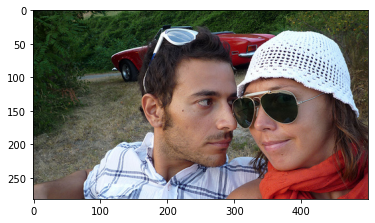

Greedy: man in black shirt is standing in front of an audience


In [52]:
pic = list(test_features.keys())[np.random.randint(len(test_features))]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

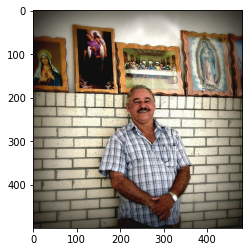

Greedy: man in black shirt is standing in front of building


In [53]:
pic = list(test_features.keys())[np.random.randint(len(test_features))]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

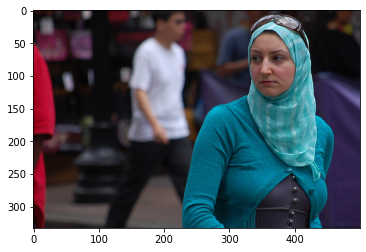

Greedy: two young boys are playing in the grass


In [54]:
pic = list(test_features.keys())[np.random.randint(len(test_features))]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

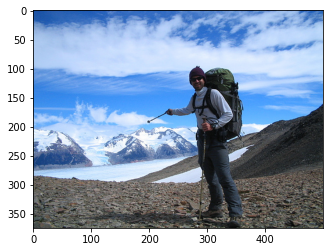

Description -  man in red shirt is climbing rock face


In [34]:
img_features = encode("abhi.jpg").reshape((1, 2048))
x = plt.imread("abhi.jpg")
plt.imshow(x)
plt.show()
print("Description - ", greedySearch(img_features))

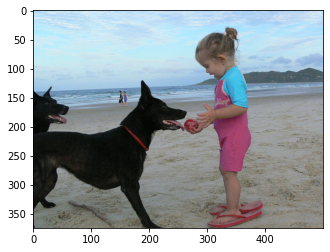

Description -  black dog is running through the water


In [35]:
img_features = encode("dog.jpg").reshape((1, 2048))
x = plt.imread("dog.jpg")
plt.imshow(x)
plt.show()
print("Description - ", greedySearch(img_features))

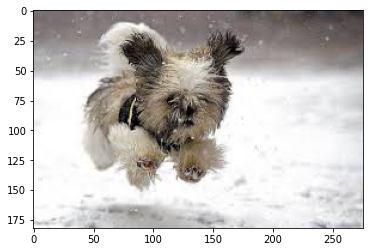

Description -  dog is running through the snow


In [36]:
img_features = encode("dog2.jpeg").reshape((1, 2048))
x = plt.imread("dog2.jpeg")
plt.imshow(x)
plt.show()
print("Description - ", greedySearch(img_features))